In [1]:
from typing import Final

from models.base_llm import BaseLLM
from models.ollama_llm import OllamaLLM

from datasets import load_dataset
from utils.metrics import execution_metrics, plot_metrics
import pandas as pd

from utils.persistent import save_nl2sf, load_nl2sf, save_smcdel_result, load_smcdel_result, save_direct_result, \
    load_direct_result, NameInfo
from models.openai_llm import OpenAILLM
from utils.preprocess import preprocess
from utils.prompt import get_smcdel_prompt, get_direct_prompt
from executors.smcdel import SMCDEL
from tqdm import tqdm
import warnings

warnings.simplefilter(action='ignore', category=DeprecationWarning)
tqdm.pandas()

%load_ext autoreload
%autoreload 2

constants

In [2]:
model_name: Final[str] = "gpt-3.5-turbo"  # should be openai's model or ollama's model
random_state: Final[int] = 1
sample_size: Final[int] = 50

parameters

In [3]:
name_info: Final[NameInfo] = {
    "model_name": model_name,
    "random_state": random_state,
    "sample_size": sample_size
}

# Data

## 1. Load Data

In [4]:
# since the dataset is not used as any training process, we can load the whole dataset
dataset = load_dataset("sileod/mindgames", cache_dir='./data')
d1 = pd.DataFrame(dataset['test'])
all_data = pd.concat([d1])
examples = pd.DataFrame(dataset['train']).groupby('setup').apply(lambda x: x.sample(1, random_state=random_state)).reset_index(drop=True)
all_data = all_data.drop(examples.index)
all_data = all_data.dropna()

## 2. Data Exploration

data showcase

In [5]:
all_data.head(5)

,premise,smcdel_problem,n_announcements,pbcheck,hypothesis,setup,hypothesis_depth,n_agents,label,names,index,s-l,deberta_pred,deberta_confidence,difficulty
4,There are four persons. Everyone is visible to...,"VARS 1,2,3,4 LAW Top OBS Agenta:3 Agentb:2 Age...",1,"VARS 0,1,2,3,4 LAW Top OBS Agenta:3 Agentb:2 A...",Andrew can now know whether Willie can know th...,explicit,1,4,entailment,"[Nathaniel, Raymond, Willie, Andrew]",55199,explicit-1,1,0.940522,0.059478
5,There are three persons. Everyone is visible t...,"VARS 1,2,3 LAW Top OBS Agenta:1,2,3 Agentb:1,2...",1,"VARS 0,1,2,3 LAW Top OBS Agenta:1,2,3 Agentb:1...",Margaret can now know that Jennifer can know t...,forehead_mirror,1,3,not_entailment,"[Margaret, Jennifer, Howard]",2974,forehead_mirror-0,0,0.998567,0.001433
6,There are four persons. Everyone is visible to...,"VARS 1,2,3,4 LAW Top OBS Agenta:1,2,3,4 Agentb...",4,"VARS 0,1,2,3,4 LAW Top OBS Agenta:1,2,3,4 Agen...",Jennifer can now know whether Esther can know ...,forehead_mirror,1,4,entailment,"[Maranda, Esther, Melissa, Jennifer]",12924,forehead_mirror-1,1,0.999778,0.000222
7,There are four persons. Everyone is visible to...,"VARS 1,2,3,4 LAW Top OBS Agenta:1,2,3,4 Agentb...",4,"VARS 0,1,2,3,4 LAW Top OBS Agenta:1,2,3,4 Agen...",Joyce can now know whether Brian can know whet...,forehead_mirror,1,4,entailment,"[Chad, Joyce, Shawn, Brian]",53967,forehead_mirror-1,1,0.999752,0.000248
8,There are three persons. Everyone is visible t...,"VARS 1,2,3 LAW Top OBS Agenta:3 Agentb:1 VALID...",2,"VARS 0,1,2,3 LAW Top OBS Agenta:3 Agentb:1 VAL...",Joseph can now know whether someone picked a r...,explicit,0,3,entailment,"[Joseph, Sally, Donna]",52384,explicit-1,1,0.999783,0.000217


examples showcase

In [6]:
examples

,premise,smcdel_problem,n_announcements,pbcheck,hypothesis,setup,hypothesis_depth,n_agents,label,names,index,s-l,deberta_pred,deberta_confidence,difficulty
0,There are two persons. Everyone is visible to ...,"VARS 1,2 LAW Top OBS Agenta:2 Agentb:1,2 VALID...",1,"VARS 0,1,2 LAW Top OBS Agenta:2 Agentb:1,2 VAL...",Patricia can now know whether someone picked a...,explicit,0,2,entailment,"[Loyd, Patricia]",55517,explicit-1,1,0.999451,0.000549
1,There are four persons. Everyone is visible to...,"VARS 1,2,3,4 LAW Top OBS Agenta:2,3,4 Agentb:1...",3,"VARS 0,1,2,3,4 LAW Top OBS Agenta:2,3,4 Agentb...",Lewis can now know whether Joyce can know that...,forehead,1,4,entailment,"[Joyce, Laura, Lewis, Erika]",37251,forehead-1,1,0.993485,0.006515
2,There are two persons. Everyone is visible to ...,"VARS 1,2 LAW Top OBS Agenta:1,2 Agentb:1,2 VAL...",2,"VARS 0,1,2 LAW Top OBS Agenta:1,2 Agentb:1,2 V...",Vanessa can now know that Thomas can know that...,forehead_mirror,1,2,not_entailment,"[Vanessa, Thomas]",14276,forehead_mirror-0,0,0.998877,0.001123
3,There are four persons. Everyone is visible to...,"VARS 1,2,3,4 LAW Top OBS Agenta:1 Agentb:2 Age...",2,"VARS 0,1,2,3,4 LAW Top OBS Agenta:1 Agentb:2 A...",Rachel can now know that Pierre can know wheth...,internal,1,4,entailment,"[Michael, Mark, Rachel, Pierre]",48706,internal-1,1,0.727491,0.272509


list all columns

In [7]:
list(all_data.columns)

['premise',
 'smcdel_problem',
 'n_announcements',
 'pbcheck',
 'hypothesis',
 'setup',
 'hypothesis_depth',
 'n_agents',
 'label',
 'names',
 'index',
 's-l',
 'deberta_pred',
 'deberta_confidence',
 'difficulty']

## 3. Data Preprocessing

In [8]:
examples = preprocess(examples)
all_data = preprocess(all_data)

preprocessed data showcase

In [9]:
all_data.head(5)

,setup,context,hypothesis,target_sf,target_label,n_announcements,n_agents,hypothesis_depth
4,explicit,There are four persons. Their names are Nathan...,Andrew can now know whether Willie can know th...,"VARS 1,2,3,4 LAW Top OBS Agenta:3 Agentb:2 Age...",1,1,4,1
5,forehead_mirror,There are three persons. Their names are Marga...,Margaret can now know that Jennifer can know t...,"VARS 1,2,3 LAW Top OBS Agenta:1,2,3 Agentb:1,2...",0,1,3,1
6,forehead_mirror,There are four persons. Their names are Marand...,Jennifer can now know whether Esther can know ...,"VARS 1,2,3,4 LAW Top OBS Agenta:1,2,3,4 Agentb...",1,4,4,1
7,forehead_mirror,"There are four persons. Their names are Chad, ...",Joyce can now know whether Brian can know whet...,"VARS 1,2,3,4 LAW Top OBS Agenta:1,2,3,4 Agentb...",1,4,4,1
8,explicit,There are three persons. Their names are Josep...,Joseph can now know whether someone picked a r...,"VARS 1,2,3 LAW Top OBS Agenta:3 Agentb:1 VALID...",1,2,3,0


## 4. Prompt Example preparation 

In [10]:
internal_sample = examples[examples['setup'] == 'internal'].sample(1, random_state=random_state).iloc[0]
forehead_sample = examples[examples['setup'] == 'forehead'].sample(1, random_state=random_state).iloc[0]
explicit_sample = examples[examples['setup'] == 'explicit'].sample(1, random_state=random_state).iloc[0]
forehead_mirror_sample = examples[examples['setup'] == 'forehead_mirror'].sample(1, random_state=random_state).iloc[0]


def choose_example(setup: str) -> pd.Series:
    """
    Choose an example from the train set based on the setup
    :param setup: 
    :return: 
    """
    if setup == 'internal':
        return internal_sample
    elif setup == 'forehead':
        return forehead_sample
    elif setup == 'explicit':
        return explicit_sample
    elif setup == 'forehead_mirror':
        return forehead_mirror_sample
    else:
        raise ValueError(f"Invalid setup: {setup}")


## 5. Samples Preparation

In [11]:
test_samples = all_data[
    (all_data['n_agents'] == 3) & (all_data['hypothesis_depth'] == 1) & (all_data['n_announcements'] == 2)]
test_samples = test_samples.groupby([
    'target_label',
], observed=True).sample(sample_size, random_state=random_state,
                         replace=False)

print("Total sample size: ", len(test_samples))
# tom_lm: Add columns for the predicted sf, predicated_label
tom_lm_samples = test_samples.copy()
tom_lm_samples['predicted_sf'] = ""
tom_lm_samples['predicted_label'] = -1
# direct: Add columns for the predicted_label
direct_lm_samples = test_samples.copy()
direct_lm_samples['predicted_label'] = -1

Total sample size:  100


# Model Initialization

In [12]:
if model_name in {"gpt-3.5-turbo", "gpt-4"}:
    model = OpenAILLM(model_name=model_name)
elif model_name == "gemma":
    model = OllamaLLM(model_name=model_name)
else:
    raise ValueError(f"Invalid model name: {model_name}")

print(model)

model: BaseLLM = model

# Run

## 1. LLM Direct Prediction

In [13]:
model.reconfigure(config={"max_tokens": 10})

In [14]:
def direct_predict(row: pd.Series):
    # choose example prompt based on 'setup'
    setup = row['setup']
    example = choose_example(setup)
    # form prompt
    context = row['context']
    hypothesis = row['hypothesis']
    prompt = get_direct_prompt(
        example_context=example['context'],
        example_hypothesis=example['hypothesis'],
        example_answer="TURE" if example['target_label'] == 1 else "FALSE",
        context=context,
        hypothesis=hypothesis
    )
    # do completion
    answer = model.complete(prompt)
    if answer == "TRUE":
        answer = 1
    elif answer == "FALSE":
        answer = 0
    else:
        answer = -1
    # store predicted symbolic formulation to original df
    row['predicted_label'] = answer
    return row


direct_lm_samples = direct_lm_samples.progress_apply(direct_predict, axis=1)

100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


In [15]:
save_direct_result(direct_lm_samples, name_info=name_info)

## 2. LLM+SMCDEL Prediction

In [16]:
model.reconfigure(config={"max_tokens": 300,"model_name": "ft:gpt-3.5-turbo-0125:personal::99y5SlF1"})

### a. Natural Language to Symbolic Formulation
LLM will predict the symbolic formulation based on the natural language context and hypothesis

In [17]:
def nl2sf_predict(row: pd.Series):
    # choose example prompt based on 'setup'
    setup = row['setup']
    example = choose_example(setup)
    # form prompt
    context = row['context']
    hypothesis = row['hypothesis']
    prompt = get_smcdel_prompt(
        example_context=example['context'],
        example_hypothesis=example['hypothesis'],
        example_sf=example['target_sf'],
        problem_context=context,
        problem_hypothesis=hypothesis
    )
    # do completion
    sf = model.complete(prompt)
    # store predicted symbolic formulation to original df
    row['predicted_sf'] = sf
    return row


tom_lm_samples = tom_lm_samples.progress_apply(nl2sf_predict, axis=1)

100%|██████████| 100/100 [03:47<00:00,  2.27s/it]


In [18]:
save_nl2sf(tom_lm_samples, name_info=name_info)

### b. SMCDEL Execution

In [19]:
tom_lm_samples = load_nl2sf(name_info=name_info)
tom_lm_samples.head(1)

,setup,context,hypothesis,target_sf,target_label,n_announcements,n_agents,hypothesis_depth,predicted_sf,predicted_label
2973,forehead,There are three persons. Their names are Sharo...,Ashley can now know whether Sharon can know th...,"VARS 1,2,3 LAW Top OBS Agenta:2,3 Agentb:1,3 A...",0,2,3,1,"VARS 1,2,3 LAW Top OBS Agenta:2,3 Agentb:1,3 A...",-1


In [20]:
def sf_predict(row: pd.Series):
    """
    Feed predicted symbolic formulation to SMCDEL and get 1 for True, 0 for False, -1 for execution failure
    :param row: 
    :return: 
    """
    sf = row['predicted_sf']
    try:
        result = SMCDEL(text=sf)
        result = 1 if result else 0
    except ValueError as e:
        result = -1
    row['predicted_label'] = result
    return row


tom_lm_samples = tom_lm_samples.apply(sf_predict, axis=1)


In [21]:
save_smcdel_result(tom_lm_samples, name_info=name_info)

# Evaluation


## 1. Load Results

In [22]:
tom_lm_samples = load_smcdel_result(name_info=name_info)
direct_lm_samples = load_direct_result(name_info=name_info)

## 2. Metrics

### a. LLM Direct Prediction

In [23]:
direct_lm_samples['predicted_label'].value_counts().sort_index(ascending=False)

predicted_label
1    24
0    76
Name: count, dtype: int64

In [24]:
direct_lm_samples['predicted_label'].value_counts(normalize=True).sort_index(ascending=False).mul(100).round(2).astype(
    'str') + '%'

predicted_label
1    24.0%
0    76.0%
Name: proportion, dtype: object

In [25]:
execution_metrics(direct_lm_samples)

,execution_accuracy,auc,f1,execution_rate
setup,,,,
explicit,0.333333,0.545455,0.166667,1.0
forehead,0.645161,0.500000,0.000000,1.0
forehead_mirror,0.500000,0.531469,0.625000,1.0
internal,0.500000,0.558824,0.210526,1.0
overall,0.520000,0.520000,0.351351,1.0


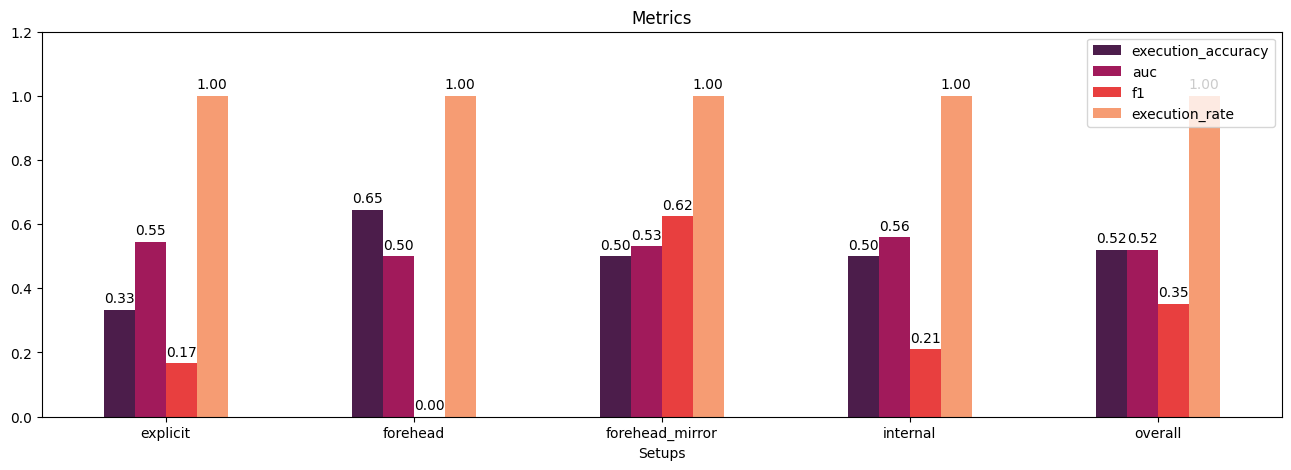

In [26]:
plot_metrics(direct_lm_samples)

### b. LLM+SMCDEL Prediction

In [27]:
tom_lm_samples['predicted_label'].value_counts().sort_index(ascending=False)

predicted_label
1    51
0    49
Name: count, dtype: int64

In [28]:
tom_lm_samples['predicted_label'].value_counts(normalize=True).sort_index(ascending=False).mul(100).round(2).astype(
    'str') + '%'

predicted_label
1    51.0%
0    49.0%
Name: proportion, dtype: object

In [29]:
tom_lm_samples

,setup,context,hypothesis,target_sf,target_label,n_announcements,n_agents,hypothesis_depth,predicted_sf,predicted_label
2973,forehead,There are three persons. Their names are Sharo...,Ashley can now know whether Sharon can know th...,"VARS 1,2,3 LAW Top OBS Agenta:2,3 Agentb:1,3 A...",0,2,3,1,"VARS 1,2,3 LAW Top OBS Agenta:2,3 Agentb:1,3 A...",0
1203,forehead,There are three persons. Their names are James...,Lisa can now know that Linda can know that eve...,"VARS 1,2,3 LAW Top OBS Agenta:2,3 Agentb:1,3 A...",0,2,3,1,"VARS 1,2,3 LAW Top OBS Agenta:2,3 Agentb:1,3 A...",0
1290,internal,There are three persons. Their names are Garfi...,Steven can now know that Troy can know that Ga...,"VARS 1,2,3 LAW Top OBS Agenta:1 Agentb:2 Agent...",0,2,3,1,"VARS 1,2,3 LAW Top OBS Agenta:1 Agentb:2 Agent...",0
3139,forehead,There are three persons. Their names are Kelle...,Kelley can now know that Barbara can know that...,"VARS 1,2,3 LAW Top OBS Agenta:2,3 Agentb:1,3 A...",0,2,3,1,"VARS 1,2,3 LAW Top OBS Agenta:2,3 Agentb:1,3 A...",0
2004,internal,There are three persons. Their names are Letha...,Devin can now know that Letha can know that Le...,"VARS 1,2,3 LAW Top OBS Agenta:1 Agentb:2 Agent...",0,2,3,1,"VARS 1,2,3 LAW Top OBS Agenta:1 Agentb:2 Agent...",0
...,...,...,...,...,...,...,...,...,...,...
1544,forehead,There are three persons. Their names are Eliza...,Debrah can now know that William can know that...,"VARS 1,2,3 LAW Top OBS Agenta:2,3 Agentb:1,3 A...",1,2,3,1,"VARS 1,2,3 LAW Top OBS Agenta:2,3 Agentb:1,3 A...",1
2460,forehead_mirror,There are three persons. Their names are Samue...,Leslie can now know that Samuel can know wheth...,"VARS 1,2,3 LAW Top OBS Agenta:1,2,3 Agentb:1,2...",1,2,3,1,"VARS 1,2,3 LAW Top OBS Agenta:1,2,3 Agentb:1,2...",1
1245,explicit,There are three persons. Their names are James...,Max can now know that James can know whether o...,"VARS 1,2,3 LAW Top OBS Agenta:1,3 Agentb:1,2,3...",1,2,3,1,"VARS 1,2,3 LAW Top OBS Agenta:1,3 Agentb:3 Age...",1
833,forehead,"There are three persons. Their names are Mary,...",James can now know whether Mary can know wheth...,"VARS 1,2,3 LAW Top OBS Agenta:2,3 Agentb:1,3 A...",1,2,3,1,"VARS 1,2,3 LAW Top OBS Agenta:2,3 Agentb:1,3 A...",1


In [30]:
execution_metrics(tom_lm_samples)

,execution_accuracy,auc,f1,execution_rate
setup,,,,
explicit,0.933333,0.875,0.956522,1.0
forehead,1.000000,1.000,1.000000,1.0
forehead_mirror,1.000000,1.000,1.000000,1.0
internal,1.000000,1.000,1.000000,1.0
overall,0.990000,0.990,0.990099,1.0


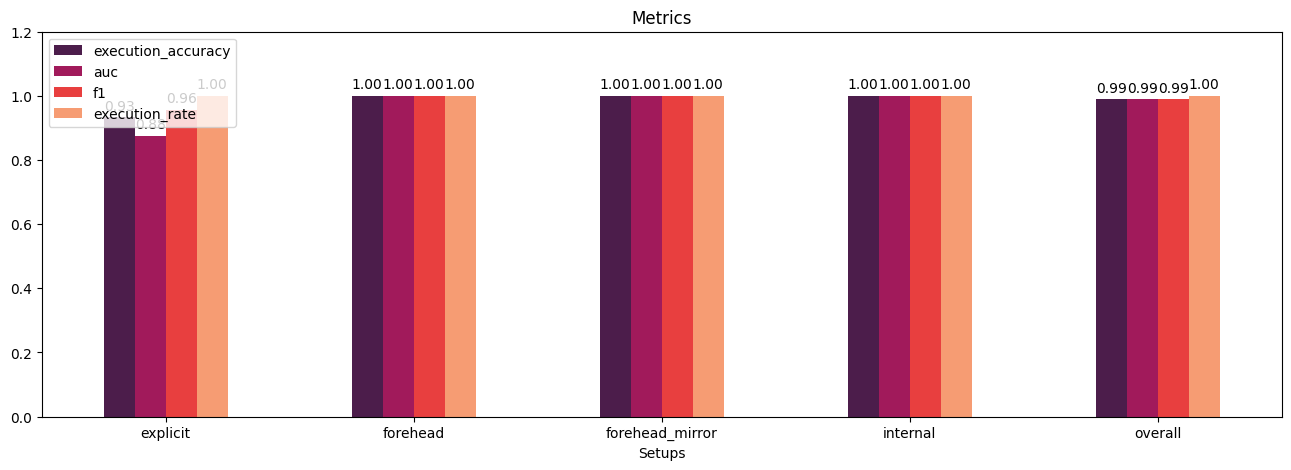

In [31]:
plot_metrics(tom_lm_samples)